In [2]:
import numpy as np 
import tensorly as tl
import sys
sys.path.append("../mfda/")
from tensor_decomposition import MARGARITA
from marginal_product_basis import MPB
from utility import FPCA 
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import BSpline, Tensor
from skfda.misc.operators import LinearDifferentialOperator, gram_matrix
from skfda.preprocessing.smoothing import BasisSmoother
from skfda import FDataGrid

from sklearn.metrics import r2_score, mean_squared_error
from collections import namedtuple 
import time 
import os 
import itertools 
import pickle 
import scipy 
from scipy.stats import ortho_group, sem
import pandas as pd 
import functools 
import operator 

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

svdtuple = namedtuple("SVD", ["U", "s", "Vt"])
DATA_DIR = "data"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define utility functions.

In [6]:
## Wrapper function for K-oMPB estimation using MARGARITA [1]
def kompb(Y, K):
    ## Compute basis evaluation matrices and SVDs
    Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
    ## Specify differential operator for penalization 
    D2 = LinearDifferentialOperator(2)
    Rlst = [gram_matrix(D2, bspline_basis[d]) for d in range(nmode)] 
    ## Perform the n-mode coordinate transformations into the spline coefficient space 
    ## Y_Bar should be close to zero so no need to center 
    G = tl.tenalg.multi_mode_dot(Y, [svdt.U.T for svdt in Svds], list(range(nmode)))
    ## Estimation MPB
    maxiter = (200, 100)
    tol_inner = (1e-3, 1e-3)
    tol_outer = 1e-3
    initialize = "random"
    Vs = [Svds[d].Vt.T for d in range(nmode)]
    Dinvs = [np.diag(1./Svds[d].s) for d in range(nmode)]
    Tlst_bcd = [Dinvs[d]@Vs[d].T@Rlst[d]@Vs[d]@Dinvs[d] for d in range(nmode)]
    pen_params = (1e-10, 1e-10, 1e-10) ## no noise in simulation so regularization can be mild 
    start = time.time()
    Ctilde, Smat, scalars, FLAG_C, FLAG_N = MARGARITA(G, Tlst_bcd, pen_params, K, 
                                     max_iter=maxiter, tol_inner=tol_inner, 
                                     tol_outer=tol_outer,  regularization="l2", init=initialize, 
                                    verbose=False)
    elapsed = time.time() - start
    Clst = [Svds[d].Vt.T @ np.diag(1/Svds[d].s) @ Ctilde[d] for d in range(nmode)] 
    Smat_scaled = np.multiply(Smat, scalars)
    Zeta_tensor = np.zeros((K,n1,n2))
    for k in range(K):
        Zeta_tensor[k,:,:] = (Phis[0] @ Clst[0][:,k]).reshape(-1,1) @ (Phis[1] @ Clst[1][:,k]).reshape(-1,1).T
    return Zeta_tensor, Clst, Smat_scaled 

## Wrapper function for two stage FPCA from [1]
def two_stage_fpca(Zeta_tensor, Clst, Smat_scaled, K):
    mpb = MPB(bspline_basis, Clst)
    ## Perform FPCA 
    J = mpb.gram_matrix()
    R = mpb.roughness_matrix()
    B, gamma = FPCA(Smat_scaled, J, R, lam=1e-10)
    Eta_tensor = tl.tenalg.mode_dot(Zeta_tensor, B.T, 0)
    return Eta_tensor
    
## Implementation of marginal product FPCA from [2]
def marginal_product_fpca(Y, K):
    ## Step 1: Obtain pre-smoothed estimates 
    N = Y.shape[-1]
    tpb_smoother = BasisSmoother(tp_basis, return_basis=True)
    fd = FDataGrid(np.moveaxis(Y, [0, 1, 2], [1, 2, 0]), xgrids)
    fd_smooth = tpb_smoother.fit_transform(fd)
    Coefs_hat = fd_smooth.coefficients.reshape(N, m1, m2) ## hopefully this is the correct reshaping 

    fd_mu = FDataGrid(np.mean(Y, axis=2).reshape(1, n1,n2), xgrids)
    fd_smooth_mu = tpb_smoother.fit_transform(fd_mu)
    coefs_mu = fd_smooth_mu.coefficients.ravel().reshape(m1, m2)

    ## Step 2: Compute both marginal covariances 
    Jlst = [bsp1.gram_matrix(), bsp2.gram_matrix()]
    G_x1 = np.zeros((m1,m1))
    G_x2 = np.zeros((m2, m2))

    for n in range(N):
        G_x1 = G_x1 + Coefs_hat[n,:,:] @ Jlst[1] @ Coefs_hat[n,:,:].T
        G_x2 = G_x2 + Coefs_hat[n,:,:].T @ Jlst[0] @  Coefs_hat[n,:,:]

    G_x1 = G_x1/N
    G_x2 = G_x2/N

    ## Step 3: Perform FPCA using standard methods 
    Eigenlst = [np.linalg.eig(Jlst[0]), np.linalg.eig(Jlst[1])]
    Jsqrt_lst = [Eigenlst[0][1] @ np.diag(np.sqrt(Eigenlst[0][0])) @ Eigenlst[0][1].T, 
                 Eigenlst[1][1] @ np.diag(np.sqrt(Eigenlst[1][0])) @ Eigenlst[1][1].T]
    Jinvsqrt_lst = [Eigenlst[0][1] @ np.diag(1/np.sqrt(Eigenlst[0][0])) @ Eigenlst[0][1].T, 
                 Eigenlst[1][1] @ np.diag(1/np.sqrt(Eigenlst[1][0])) @ Eigenlst[1][1].T]

    fpca_x1 = np.linalg.eig(Jsqrt_lst[0] @ G_x1 @ Jsqrt_lst[0])
    fpca_x2 =  np.linalg.eig(Jsqrt_lst[1] @ G_x2 @ Jsqrt_lst[1])

    eige_coefs_x1 = Jinvsqrt_lst[0] @ fpca_x1[1]
    eige_coefs_x2 = Jinvsqrt_lst[1] @ fpca_x2[1]

    eigenvalues = fpca_x1[0].reshape(-1,1) @ fpca_x2[0].reshape(1,-1)
    eigenvalues_orderd = -np.sort(-eigenvalues.ravel())
    ordering = []
    for ev in eigenvalues_orderd:
        xo, yo = np.where(eigenvalues == ev)
        ordering.append((xo[0],yo[0]))

    ## Step 4: Create regression matrix 
    MFPCA_tensor = np.zeros((K,n1,n2))
    for k in range(K):
        k1, k2 = ordering[k]
        MFPCA_tensor[k, :, :] = (Phis[0] @ eige_coefs_x1[:,k1].reshape(-1,1)) @ (Phis[1] @ eige_coefs_x2[:,k2].reshape(-1,1)).T
        
    return MFPCA_tensor

def non_separable_bias(Coefs, lambdas, Clst):
    K = Clst[0].shape[1]
    Jlst = [bsp1.gram_matrix(), bsp2.gram_matrix()]
    JC0 = Jlst[0] @ Clst[0]
    JC1 = Clst[1].T @ Jlst[1]
    V = np.block([np.kron(JC1[kk,:].reshape(1,-1).T, JC0[:,kk].reshape(-1,1)) for kk in range(K)])
    NSB = 0 
    for k in range(K):
        rho_k = lambdas[k]
        A_k = Coefs[k,].reshape(m1, m2)
        JAJ_k = Jlst[0] @ A_k @ Jlst[1]
        a_k = JAJ_k.reshape((-1, 1), order="F") ## stacking columns 
        b_k, res, rank, s = np.linalg.lstsq(V, a_k, rcond=None)
        Diff = A_k - Clst[0] @ np.diag(b_k.ravel()) @ Clst[1].T
        NSB += rho_k*(np.linalg.norm(Jlst[0] @ Diff @ Jlst[1], ord="fro")**2)
    return NSB

# Construct Random Functions

In [7]:
np.random.seed(15) ## make exactly reproducible 

n1 = 100
n2 = 100
m1 = 10
m2 = 8
bsp1 = BSpline(n_basis=m1, order=4)
bsp2 = BSpline(n_basis=m2, order=4)

## Global parameters 
nmode = 2
bspline_basis = [bsp1, bsp2] ## use true marginal basis systems for all fitting methods 
xgrids = [np.linspace(0,1,n1),
         np.linspace(0,1,n2)]
Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]

X = np.array(list(itertools.product(*xgrids)))
tp_basis = Tensor([bsp1, bsp2])
J_tp = tp_basis.gram_matrix()

Phi = np.squeeze(tp_basis.evaluate(X)).T

lambdas = np.exp(-0.5*np.arange(m1*m2)) #exponential decay model for eigenfunctions 

s_tp, P_tp = np.linalg.eigh(J_tp)
Coefs = np.diag(np.sqrt(1./s_tp))@P_tp.T 

Q = ortho_group.rvs(m1*m2)
Coefs = Q@Coefs

Psi_tensor = np.zeros((m1*m2,n1,n2))
for k in range(m1*m2):
    Psi_tensor[k,:,:] = (Phi @ Coefs[k,:]).reshape(n1,n2)

/var/folders/pm/g__q_d9n2616jp5gx5z8d6tr0000gn/T/ipykernel_11369/4068993027.py:15: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]
/var/folders/pm/g__q_d9n2616jp5gx5z8d6tr0000gn/T/ipykernel_11369/4068993027.py:21: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  Phi = np.squeeze(tp_basis.evaluate(X)).T


# Estimation

Estimate the MSE on an independent random test set for several ranks using all methods.

In [8]:
Ranks = [3, 5, 10, 15, 20, 30]
Ns = [5, 10, 15, 20, 50, 100]
Ntest = 50; Nreps = 25
MSEs = np.zeros((len(Ns), len(Ranks), Nreps, 3))

for ni, Ntrain in enumerate(Ns):
    for ki, k in enumerate(Ranks):
        for rep in range(Nreps):
            Y = np.zeros((n1,n2,Ntrain+Ntest))
            Psi_coefs = np.random.multivariate_normal(np.zeros(m1*m2), np.diag(lambdas), size=Ntrain+Ntest)
            for i in range(Ntrain+Ntest): 
                Y[:,:,i] = functools.reduce(operator.add,map(lambda k: Psi_coefs[i,k]*Psi_tensor[k,:,:], np.arange(m1*m2)))
            Y_train_N = Y[:,:,0:Ntrain]
            Y_test = Y[:,:,Ntrain:]

            Zeta_tensor, Clst, Smat_scaled = kompb(Y_train_N, k)
            MFPCA_tensor = marginal_product_fpca(Y_train_N, k)

            Zeta_k = tl.base.unfold(Zeta_tensor[0:k,:,:], 0).T
            Zeta_cmapper_k = np.linalg.inv(Zeta_k.T @ Zeta_k)@ Zeta_k.T 

            MFPCA_k = tl.base.unfold(MFPCA_tensor[0:k,:,:], 0).T
            MFPCA_cmapper_k = np.linalg.inv(MFPCA_k.T @ MFPCA_k)@ MFPCA_k.T 

            Psi_k = tl.base.unfold(Psi_tensor[0:k,:,:], 0).T
            Psi_cmapper_k = np.linalg.inv(Psi_k.T @ Psi_k)@ Psi_k.T 
            
            MSE_ni_ki_nrep = np.zeros((Ntest,3))
            for n in range(Ntest):
                y_n = tl.base.tensor_to_vec(Y_test[:,:,n])

                coefs_zeta_n = Zeta_cmapper_k @ y_n
                coefs_mfpca_n = MFPCA_cmapper_k @ y_n
                coefs_psi_n = Psi_cmapper_k @ y_n

                Yhat_zeta_n = tl.tenalg.mode_dot(Zeta_tensor[0:k,:,:], coefs_zeta_n, 0)
                Yhat_mfpca_n = tl.tenalg.mode_dot(MFPCA_tensor[0:k,:,:], coefs_mfpca_n, 0)
                Yhat_psi_n = tl.tenalg.mode_dot(Psi_tensor[0:k,:,:], coefs_psi_n, 0)

                MSE_ni_ki_nrep[n,0] = np.sum(np.power(Y_test[:,:,n] - Yhat_zeta_n, 2))/(n1*n2)
                MSE_ni_ki_nrep[n,1] = np.sum(np.power(Y_test[:,:,n] - Yhat_mfpca_n, 2))/(n1*n2)
                MSE_ni_ki_nrep[n,2] = np.sum(np.power(Y_test[:,:,n] - Yhat_psi_n, 2))/(n1*n2)
                #MSE_ni_ki_nrep[n,0] = mean_squared_error(Y_test[:,:,n], Yhat_zeta_n)
                #MSE_ni_ki_nrep[n,1] = mean_squared_error(Y_test[:,:,n], Yhat_mfpca_n)
                #MSE_ni_ki_nrep[n,2] = mean_squared_error(Y_test[:,:,n], Yhat_psi_n)
            
            MSEs[ni, ki, rep, :] = np.mean(MSE_ni_ki_nrep, 0)
            
        print("Finished rank: %s"%k)
    print("Finished training sample size: %s"%Ntrain)

Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 5
Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 10
Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 15
Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 20
Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 50
Finished rank: 3
Finished rank: 5
Finished rank: 10
Finished rank: 15
Finished rank: 20
Finished rank: 30
Finished training sample size: 100


Estimate the eigenfunctions using a two-stage FPCA procedure. 

In [10]:
Kprime = 3 
N_eigen = (50, 100, 200)
EigenApprox = np.zeros((len(N_eigen), 3, Nreps))
for ni, Ntrain in enumerate(N_eigen):
    for rep in range(Nreps):
        Y = np.zeros((n1,n2,Ntrain+Ntest))
        Psi_coefs = np.random.multivariate_normal(np.zeros(m1*m2), np.diag(lambdas), size=Ntrain+Ntest)
        for i in range(Ntrain+Ntest): 
            Y[:,:,i] = functools.reduce(operator.add,map(lambda k: Psi_coefs[i,k]*Psi_tensor[k,:,:], np.arange(m1*m2)))
        Y_train_N = Y[:,:,0:Ntrain]
        Y_test = Y[:,:,Ntrain:]
        
        Zeta_tensor, Clst, Smat_scaled = kompb(Y_train_N, 60)

        Eta_tensor = two_stage_fpca(Zeta_tensor, Clst, Smat_scaled, 60)
        for kk in range(Kprime):
            inner_product = np.abs(tl.tenalg.inner(Psi_tensor[kk,:,:], Eta_tensor[kk,:,:])/(tl.norm(Psi_tensor[kk,:,:])*tl.norm(Eta_tensor[kk,:,:])))
            EigenApprox[ni, kk, rep] = inner_product
            #mse_kk_pos = mean_squared_error(Psi_tensor[kk,:,:]/np.linalg.norm(Psi_tensor[kk,:,:]),
            #                                Eta_tensor[kk,:,:]/np.linalg.norm(Eta_tensor[kk,:,:]))
            #mse_kk_neg = mean_squared_error(-Psi_tensor[kk,:,:]/np.linalg.norm(Psi_tensor[kk,:,:]),
            #                                Eta_tensor[kk,:,:]/np.linalg.norm(Eta_tensor[kk,:,:]))
            #EigenApprox[ni, kk, rep] = np.min((mse_kk_pos,mse_kk_neg)) ## remove sign ambiguity of eigenfunctions 
    print("Finished training sample size: %s"%Ntrain)

Finished training sample size: 50
Finished training sample size: 100
Finished training sample size: 200


# Visualizations.

Test set representation MSE.

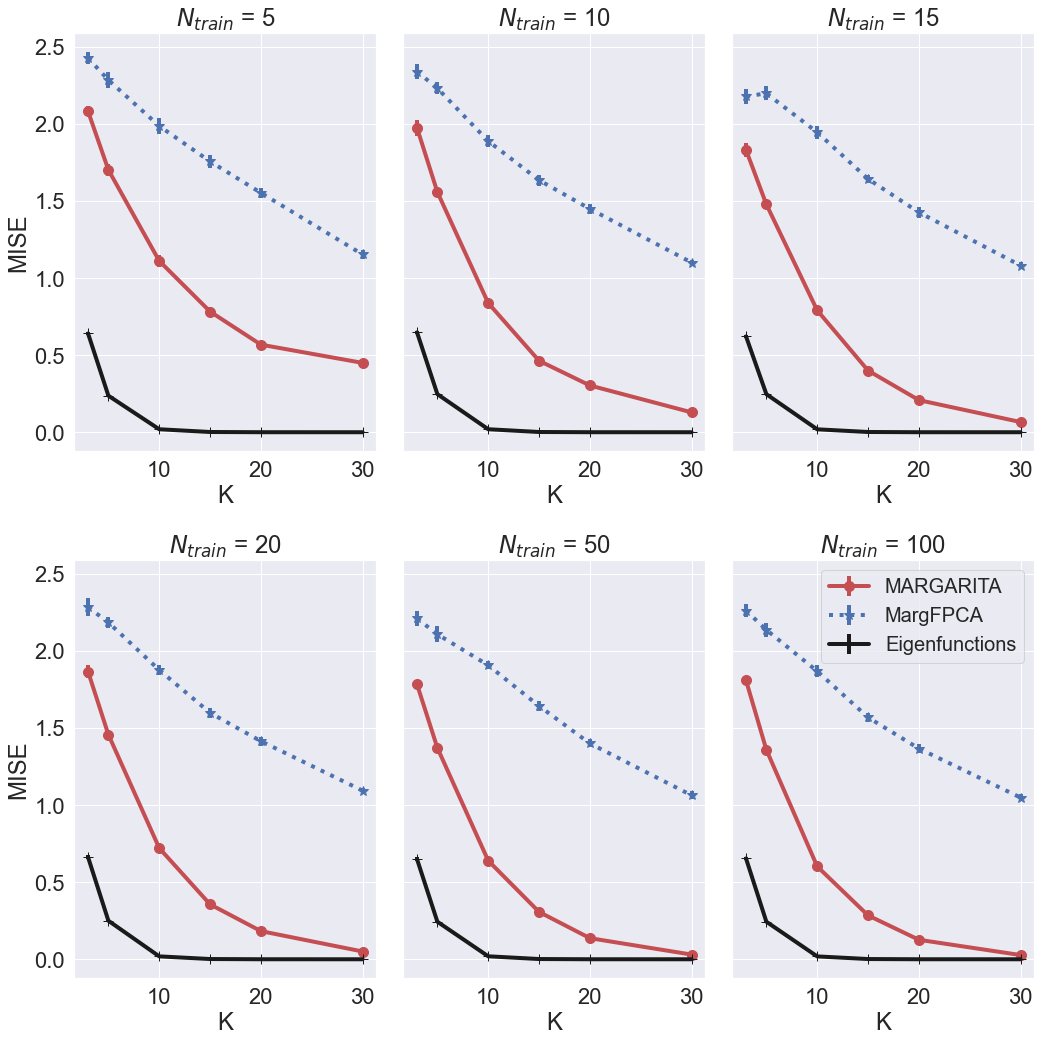

In [11]:
sns.set(font_scale = 2)
f, ax = plt.subplots(2,3,figsize=(15,15), sharey=True)
csize = 0.0
lwd = 4
mksz = 10

axs_indices = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

for ni, N in enumerate(Ns):
    aix, aiy = axs_indices[ni]
    ax_ni = ax[aix, aiy]
    
    df_mean = pd.DataFrame(np.mean(MSEs[ni,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)
    df_sem = pd.DataFrame(sem(MSEs[ni,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)

    ax_ni.errorbar(Ranks, df_mean.iloc[0].values, yerr=df_sem.iloc[0].values, fmt="or-", capsize=csize,
               linewidth=lwd, markersize=mksz, label="MARGARITA")
    ax_ni.errorbar(Ranks, df_mean.iloc[1].values, yerr=df_sem.iloc[1].values, fmt="*b:", capsize=csize,
                linewidth=lwd, markersize=mksz, label="MargFPCA")
    ax_ni.errorbar(Ranks, df_mean.iloc[2].values, yerr=df_sem.iloc[2].values, fmt="+k-", capsize=csize,
                linewidth=lwd, markersize=mksz, label="True Eigenfunctions")
    if aiy == 0:
        ax_ni.set_ylabel("MISE")
        
    ax_ni.set_xlabel("K")
    ax_ni.set_title(r'$N_{train}$ = %s'%N)
    #ax_ni.set_yscale("log")

plt.legend(["MARGARITA", "MargFPCA", "Eigenfunctions"], loc="best", fontsize=20)
f.tight_layout()
#plt.savefig("figures/MARGARITA_vs_MargFPCA_extended.pdf", bbox_inches="tight")

Pared down image for main text. 

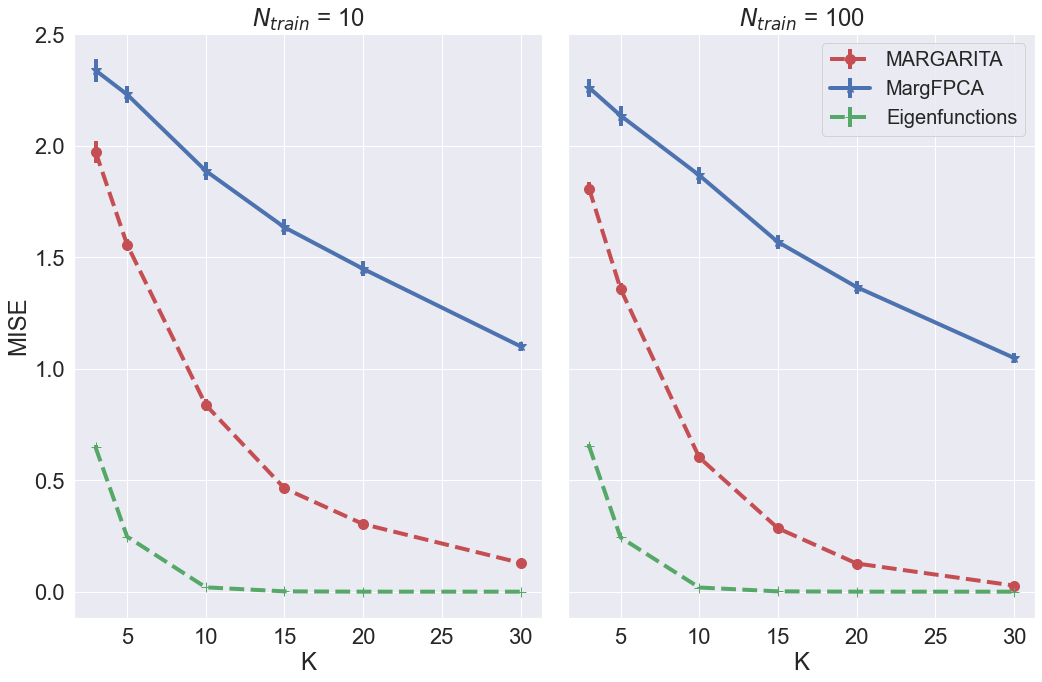

In [12]:
sns.set(font_scale = 2)
f, ax = plt.subplots(1,2,figsize=(15,10), sharey=True)
csize = 0.0
lwd = 4
mksz = 10
    
df_mean_1 = pd.DataFrame(np.mean(MSEs[1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)
df_sem_1 = pd.DataFrame(sem(MSEs[1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)

df_mean_2 = pd.DataFrame(np.mean(MSEs[-1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)
df_sem_2 = pd.DataFrame(sem(MSEs[-1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)

ax[0].errorbar(Ranks, df_mean_1.iloc[0].values, yerr=df_sem_1.iloc[0].values, fmt="or--", capsize=csize,
           linewidth=lwd, markersize=mksz, label="MARGARITA")
ax[0].errorbar(Ranks, df_mean_1.iloc[1].values, yerr=df_sem_1.iloc[1].values, fmt="*b-", capsize=csize,
            linewidth=lwd, markersize=mksz, label="MargFPCA")
ax[0].errorbar(Ranks, df_mean_1.iloc[2].values, yerr=df_sem_1.iloc[2].values, fmt="+g--", capsize=csize,
            linewidth=lwd, markersize=mksz, label="True Eigenfunctions")

ax[1].errorbar(Ranks, df_mean_2.iloc[0].values, yerr=df_sem_2.iloc[0].values, fmt="or--", capsize=csize,
           linewidth=lwd, markersize=mksz, label="MARGARITA")
ax[1].errorbar(Ranks, df_mean_2.iloc[1].values, yerr=df_sem_2.iloc[1].values, fmt="*b-", capsize=csize,
            linewidth=lwd, markersize=mksz, label="MargFPCA")
ax[1].errorbar(Ranks, df_mean_2.iloc[2].values, yerr=df_sem_2.iloc[2].values, fmt="+g--", capsize=csize,
            linewidth=lwd, markersize=mksz, label="True Eigenfunctions")

ax[0].set_xlabel("K")
ax[0].set_title(r'$N_{train}$ = 10')

ax[1].set_xlabel("K")
ax[1].set_title(r'$N_{train}$ = 100')

ax[0].set_ylabel("MISE")

plt.legend(["MARGARITA", "MargFPCA", "Eigenfunctions"], loc="best", fontsize=20)
f.tight_layout()
#plt.savefig("figures/MARGARITA_vs_MargFPCA.pdf", bbox_inches="tight")

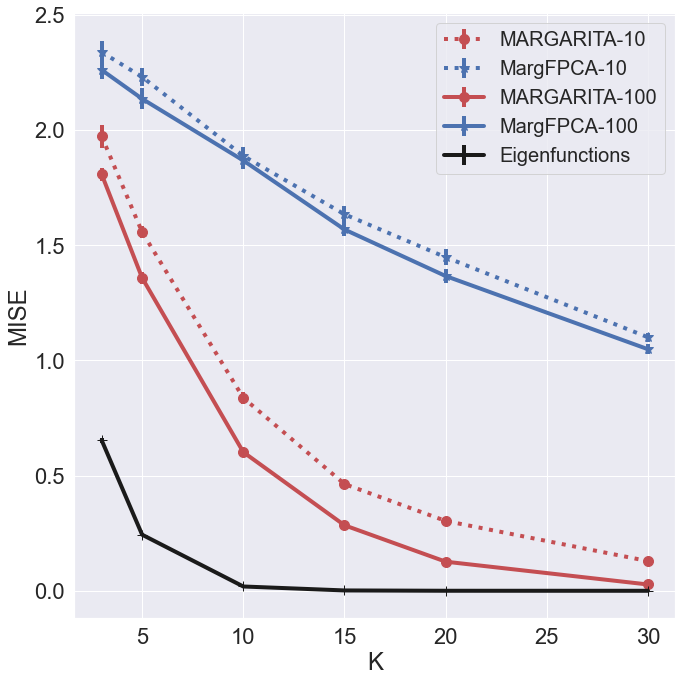

In [13]:
sns.set(font_scale = 2)
f, ax = plt.subplots(1,1,figsize=(10,10), sharey=True)
csize = 0.0
lwd = 4
mksz = 10
    
df_mean_1 = pd.DataFrame(np.mean(MSEs[1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)
df_sem_1 = pd.DataFrame(sem(MSEs[1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)

df_mean_2 = pd.DataFrame(np.mean(MSEs[-1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)
df_sem_2 = pd.DataFrame(sem(MSEs[-1,:,:,:], 1).T,index=["K-oMPB","MFPCA","Eigenfunctions"], columns=Ranks)

ax.errorbar(Ranks, df_mean_1.iloc[0].values, yerr=df_sem_1.iloc[0].values, fmt="or:", capsize=csize,
           linewidth=lwd, markersize=mksz, label="MARGARITA-10")
ax.errorbar(Ranks, df_mean_1.iloc[1].values, yerr=df_sem_1.iloc[1].values, fmt="*b:", capsize=csize,
            linewidth=lwd, markersize=mksz, label="MargFPCA-10")

ax.errorbar(Ranks, df_mean_2.iloc[0].values, yerr=df_sem_2.iloc[0].values, fmt="or-", capsize=csize,
           linewidth=lwd, markersize=mksz, label="MARGARITA-100")
ax.errorbar(Ranks, df_mean_2.iloc[1].values, yerr=df_sem_2.iloc[1].values, fmt="*b-", capsize=csize,
            linewidth=lwd, markersize=mksz, label="MargFPCA-100")
ax.errorbar(Ranks, df_mean_2.iloc[2].values, yerr=df_sem_2.iloc[2].values, fmt="+k-", capsize=csize,
            linewidth=lwd, markersize=mksz, label="True Eigenfunctions")

ax.set_xlabel("K")

ax.set_ylabel("MISE")

plt.legend(["MARGARITA-10", "MargFPCA-10", "MARGARITA-100", "MargFPCA-100", "Eigenfunctions"], loc="best", fontsize=20)
f.tight_layout()
#plt.savefig("figures/MARGARITA_vs_MargFPCA.pdf", bbox_inches="tight")

In [14]:
df_mean_10 = pd.DataFrame(np.mean(MSEs[1,:,:,:2], 1),columns=["K-oMPB_10","MFPCA_10"], index=Ranks)
df_mean_20 = pd.DataFrame(np.mean(MSEs[3,:,:,:2], 1),columns=["K-oMPB_20","MFPCA_20"], index=Ranks)
df_mean_50 = pd.DataFrame(np.mean(MSEs[4,:,:,:2], 1),columns=["K-oMPB_50","MFPCA_50"], index=Ranks)
df_mean_100 = pd.DataFrame(np.mean(MSEs[5,:,:,:2], 1),columns=["K-oMPB_100","MFPCA_100"], index=Ranks)

df_sem_10 = pd.DataFrame(sem(MSEs[1,:,:,:2], 1).T,index=["K-oMPB_10","MFPCA_10"], columns=Ranks)
df_sem_20 = pd.DataFrame(sem(MSEs[3,:,:,:2], 1).T,index=["K-oMPB_20","MFPCA_20"], columns=Ranks)
df_sem_50 = pd.DataFrame(sem(MSEs[4,:,:,:2], 1).T,index=["K-oMPB_50","MFPCA_50"], columns=Ranks)
df_sem_100 = pd.DataFrame(sem(MSEs[5,:,:,:2], 1).T,index=["K-oMPB_100","MFPCA_100"], columns=Ranks)

df_final = df_mean_10.merge(df_mean_20, how='inner', left_index=True, right_index=True).merge(df_mean_50,  how='inner', 
                                                                                   left_index=True, 
                                                                                   right_index=True).merge(df_mean_100,
                                                                                                         how='inner', 
                                                                                                           left_index=True, 
                                                                                                           right_index=True)
df_final = df_final[["K-oMPB_10","K-oMPB_20","K-oMPB_50","K-oMPB_100","MFPCA_10","MFPCA_20","MFPCA_50","MFPCA_100"]]
df_final = df_final.iloc[1:]
print(df_final.round(4).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  K-oMPB\_10 &  K-oMPB\_20 &  K-oMPB\_50 &  K-oMPB\_100 &  MFPCA\_10 &  MFPCA\_20 &  MFPCA\_50 &  MFPCA\_100 \\
\midrule
5  &     1.5569 &     1.4563 &     1.3706 &      1.3583 &    2.2304 &    2.1838 &    2.1071 &     2.1354 \\
10 &     0.8375 &     0.7209 &     0.6393 &      0.6019 &    1.8874 &    1.8753 &    1.9061 &     1.8677 \\
15 &     0.4634 &     0.3560 &     0.3070 &      0.2844 &    1.6342 &    1.5978 &    1.6420 &     1.5682 \\
20 &     0.3032 &     0.1826 &     0.1368 &      0.1264 &    1.4479 &    1.4138 &    1.3990 &     1.3661 \\
30 &     0.1288 &     0.0503 &     0.0304 &      0.0273 &    1.1003 &    1.0932 &    1.0629 &     1.0484 \\
\bottomrule
\end{tabular}



/var/folders/pm/g__q_d9n2616jp5gx5z8d6tr0000gn/T/ipykernel_11369/1370590937.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_final.round(4).to_latex())


Create table of MISE as a function of $N_{train}$ for the first 3 eigenfunctions.

In [15]:
Avg_MISE = pd.DataFrame(np.mean(EigenApprox,2).T, columns=N_eigen, index=["EF-1","EF-2","EF-3"])
SE_MISE = pd.DataFrame(sem(EigenApprox,2).T, columns=N_eigen, index=["EF-1","EF-2","EF-3"])

In [16]:
print(SE_MISE.round(4).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     50  &     100 &     200 \\
\midrule
EF-1 &  0.0219 &  0.0070 &  0.0026 \\
EF-2 &  0.0344 &  0.0079 &  0.0037 \\
EF-3 &  0.0305 &  0.0064 &  0.0040 \\
\bottomrule
\end{tabular}



/var/folders/pm/g__q_d9n2616jp5gx5z8d6tr0000gn/T/ipykernel_11369/153287678.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(SE_MISE.round(4).to_latex())


Plot the first few eigenfunctions and their estimates using either method.

"\nax5 = fig.add_subplot(3,2,3,projection='3d')\nsurf5 = ax5.plot_surface(XX1, XX2, Eta_tensor[1,:,:], cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\nax5.zaxis.set_ticklabels([])\nax5.set_zlabel('k = 2', fontsize=28)\n\n\nax6 = fig.add_subplot(3,2,4,projection='3d')\nsurf6 = ax6.plot_surface(XX1, XX2, Psi_tensor[1,:,:], cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\nax6.zaxis.set_ticklabels([])\n\nax8 = fig.add_subplot(3,2,5,projection='3d')\nsurf8 = ax8.plot_surface(XX1, XX2, Eta_tensor[2,:,:], cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\nax8.zaxis.set_ticklabels([])\nax8.set_zlabel('k = 3', fontsize=28)\n\n\nax9 = fig.add_subplot(3,2,6,projection='3d')\nsurf9 = ax9.plot_surface(XX1, XX2, Psi_tensor[2,:,:], cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\nax9.zaxis.set_ticklabels([])\n\nfig.tight_layout()\n"

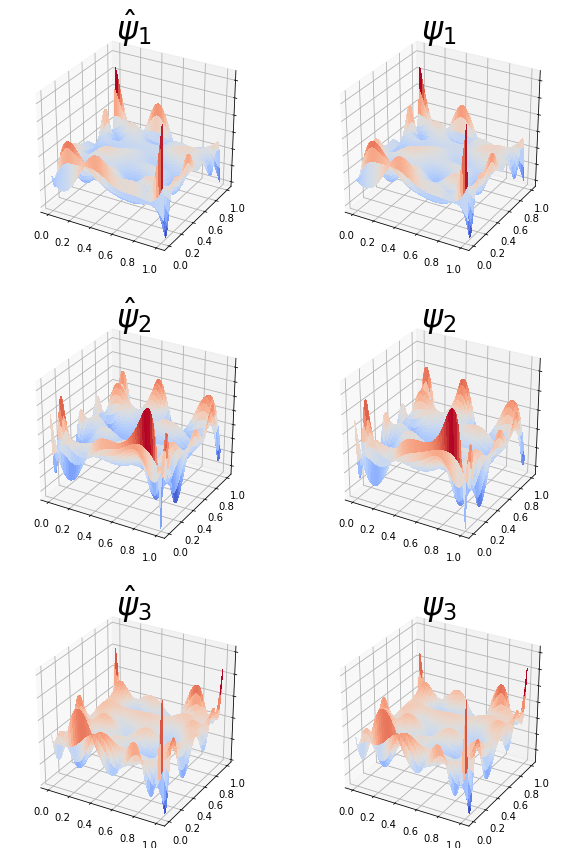

In [19]:
sns.reset_orig()

fig = plt.figure(figsize=(10, 15))

XX1, XX2 = np.meshgrid(xgrids[0], xgrids[1])

ax2 = fig.add_subplot(3,2,1,projection='3d')
surf2 = ax2.plot_surface(XX1, XX2, -Eta_tensor[0,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax2.zaxis.set_ticklabels([])
ax2.set_title(r'$\hat{\psi}_1$', fontsize=32) 

ax3 = fig.add_subplot(3,2,2,projection='3d')
surf3 = ax3.plot_surface(XX1, XX2, Psi_tensor[0,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3.zaxis.set_ticklabels([])
ax3.set_title(r'$\psi_1$', fontsize=32) 



ax5 = fig.add_subplot(3,2,3,projection='3d')
surf5 = ax5.plot_surface(XX1, XX2, Eta_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax5.set_title(r'$\hat{\psi}_2$', fontsize=32) 
ax5.zaxis.set_ticklabels([])

ax6 = fig.add_subplot(3,2,4,projection='3d')
surf6 = ax6.plot_surface(XX1, XX2, Psi_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax6.zaxis.set_ticklabels([])
ax6.set_title(r'$\psi_2$', fontsize=32) 

ax8 = fig.add_subplot(3,2,5,projection='3d')
surf8 = ax8.plot_surface(XX1, XX2, Eta_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax8.set_title(r'$\hat{\psi}_3$', fontsize=32) 
ax8.zaxis.set_ticklabels([])

ax9 = fig.add_subplot(3,2,6,projection='3d')
surf9 = ax9.plot_surface(XX1, XX2, Psi_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax9.zaxis.set_ticklabels([])
ax9.set_title(r'$\psi_3$', fontsize=32) 

#plt.savefig("figures/eigenfunction_estimation.pdf",bbox_inches="tight")

"""
ax5 = fig.add_subplot(3,2,3,projection='3d')
surf5 = ax5.plot_surface(XX1, XX2, Eta_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax5.zaxis.set_ticklabels([])
ax5.set_zlabel('k = 2', fontsize=28)


ax6 = fig.add_subplot(3,2,4,projection='3d')
surf6 = ax6.plot_surface(XX1, XX2, Psi_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax6.zaxis.set_ticklabels([])

ax8 = fig.add_subplot(3,2,5,projection='3d')
surf8 = ax8.plot_surface(XX1, XX2, Eta_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax8.zaxis.set_ticklabels([])
ax8.set_zlabel('k = 3', fontsize=28)


ax9 = fig.add_subplot(3,2,6,projection='3d')
surf9 = ax9.plot_surface(XX1, XX2, Psi_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax9.zaxis.set_ticklabels([])

fig.tight_layout()
"""

Note, due to sign unidentiabilitiy, manually changed in accordance w/ true eigenfunctions.

# Bibliography

[1] Consagra, Venkataraman, Qiu. "Efficient Multidimensional Functional Data Analysis Using Marginal Product Basis Systems".  arXiv:2107.14728. 2021.

[2] Chen, Delicado, Muller. "Modelling function-valued stochastic processes, with applications to fertility dynamics." JRSSB, 2017. 